In [5]:
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt
import random as r
import scipy.sparse as scp

In [6]:
def randomn(N,kav):
    p = kav/(N -1)
    net = nx.fast_gnp_random_graph(N, p, directed = False) 
    adj = nx.adjacency_matrix(net) # adj is a Sparse Matrix of CSR (compressed sparse row) format. 
                               # this means that row slicing is fast
    return net, adj

def remove_deadz(net,est1,N):
    # Eliminamos los nodos con estado = 2 (removed)
    net2 = net.copy()
    for i in range(0,N):
        if est1[i] == 2:
            net2.remove_node(i)
    return net2

def remove_deadzh(net,est1,N):
    # Eliminamos los nodos con estado = 2 (removed)
    net2 = net.copy()
    for i in range(0,N):
        if est1[i] == 2 or est1[i] == 3:
            net2.remove_node(i)
    return net2

def adjacency_survivors(adj2, est1, N):
    # Hacemos una nueva matriz de adyacencia en la que eliminar los links de los nodos removed
    adj3 = adj2.copy()
    adj3 = adj3.todense()
    for i in range(0,N):
        if est1[i] == 2 or est1[i] == 3: #si el nodo está removed, hay que eliminar sus links
            links = np.where(adj3[i,:] !=0. )[1]
            for l in links:
                adj3[i,l] = 0.
                adj3[l,i] = 0.
    return adj3


In [83]:
N = 4000
kav = 10
p = kav/(N-1)

net = nx.fast_gnp_random_graph(N, p, directed = False) 
adj = nx.adjacency_matrix(net) # adj is a Sparse Matrix of CSR (compressed sparse row) format. 
                               # this means that row slicing is fast

In [84]:
beta = 0.03 # infection probability in a zombie-human encounter
alpha = 0.03 # removal probability
sigma = 0.5

# "est" es un vector que guarda el estado de cada nodo de la red
#  est = 0 humano; est = 1 zombie; est = 2 zombie muerto

est = np.zeros(N, dtype = int)
est1 = np.zeros(N, dtype = int)
est2 = np.zeros(N, dtype = int)
betalist = np.zeros(N, dtype = int)

###### paciente cero: el primer infectado por el virus
pac0 = r.randint(0, N - 1)
est[pac0] = 1
est1[pac0] = 1

###### colaboradores
frac = 0.3
Nself = frac*N
cont = 0
while cont < np.int(Nself):
    hums = np.where(est1 == 0)[0]
    index = r.randint(0, N - 1)
    inside = index in hums
    if inside == True and est2[index]==0 :
        est2[index] = 2
        cont = cont + 1

it = 400
nH = np.zeros(it, dtype = int)
nZ = np.zeros(it, dtype = int)
nR = np.zeros(it, dtype = int)
nE = np.zeros(it, dtype = int)
suma = np.zeros(it, dtype = int)

for t in range(0, it): # time

    ##### RECUENTO #####
    nH[t] = len(np.where(est1 == 0)[0])
    nZ[t] = len(np.where(est1 == 1)[0])
    nR[t] = len(np.where(est1 == 2)[0])
    nE[t] = len(np.intersect1d(np.where(est1 == 0), np.where(est2 == 2)))
    
    ##### INFECTION #####
    # Identificamos los zombies en la red y las infecciones que producen
    
    zombies = np.where(est == 1)[0]
    
    for i in range(0, len(zombies)): # tenemos que buscar los contactos con humanos de cada zombie
        
        z = zombies[i] # nodo z es un zombie
        rel = adj[z,:].indices # nodos que están conectados con z
        relh = rel[est1[rel]==0] # nodos humanos conectados con z

        for j in range(0, len(relh)): # para cada nodo humano conectado con un zombie, comprobamos si está infectado
            
            h = relh[j] # humano
        
            if r.uniform(0, 1) < beta: # the node is infected
                est1[h] = 1 # human turns into zombie
                rh = adj[h,:].indices # relaciones de ese humano
                rh_self = rh[est2[rh]==2] # nodos egoistas conectados con h
                # rh_self = np.where(est2[rh] == 2)[0] # cuáles de esas relaciones son egoistas
                # numself = len(rh_self) # número de egoistas a su alrededor
                for q in rh_self:
                    if r.uniform(0,1) < sigma: # hay una probabilidad sigma de que el egoísta corte el enlace
                        net.remove_edge(h, q)
                        adj = nx.adjacency_matrix(net)


    ##### ZOMBIE REMOVAL #####
    # En cada paso temporal, eliminamos a ciertos zombies que no han sido infectados en esta misma iteración.
    
    zombies_removal = np.where(est == 1)[0] # buscamos los zombies que NO han aparecido en esta misma iteración
    for i in range(0, len(zombies_removal)):
        if r.uniform(0, 1) < alpha:
            est1[zombies_removal[i]] = 2 
    
    
    est = est1
    suma[t] = nH[t] + nZ[t] + nR[t]

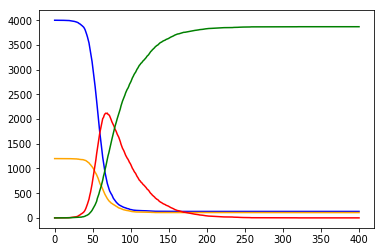

In [85]:
plt.plot( np.linspace(0,it,it), nH, color = 'blue')
plt.plot( np.linspace(0,it,it), nE, color = 'orange')
plt.plot( np.linspace(0,it,it), nZ, color = 'red')
plt.plot( np.linspace(0,it,it), nR, color = 'green')

In [86]:
print('Porcentaje de no egoistas muertos')
print((nH[0] - nE[0] - (nH[-1] - nE[-1]))/(nH[0] - nE[0]))

Porcentaje de no egoistas muertos
0.9917827795641301


In [87]:
print('Porcentaje de egoistas muertos')
print((nE[0] - nE[-1])/nE[0])

Porcentaje de egoistas muertos
0.91


In [67]:
nZ

array([1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5,
       5, 5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
it = 100
print(nH[it], nZ[it] + nR[it])
#print(nH[it] + nZ[it])
print(nH[it] + nZ[it] + nR[it])

In [73]:
net2 = remove_deadz(net,est1,N)
adj2 = adjacency_survivors(adj, est1, N)
pos = nx.fruchterman_reingold_layout(net2)


In [74]:
# asignamos colores a los nodos que tienen estado = 0 (humanos), estado = 1 (zombies)
color_list = []
for i in range(0,N):
    if est1[i] == 0 and est2[i] == 0:
        color_list.append('blue')
    elif est1[i] == 0 and est2[i] == 2:
        color_list.append('orange')
    elif est1[i] == 1:
        color_list.append('red')

C:\Users\yomis\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


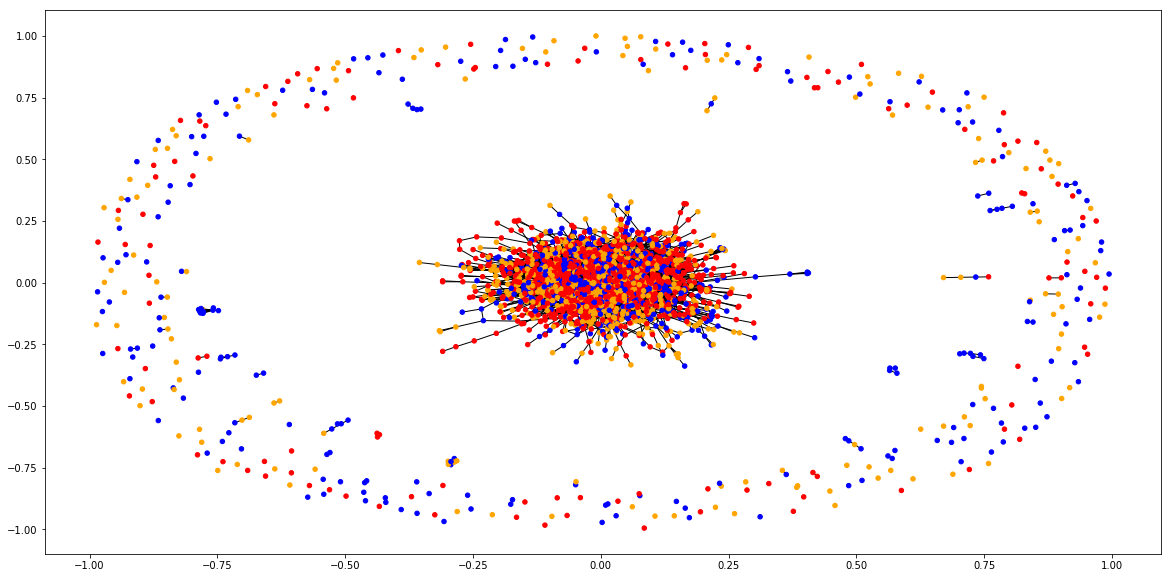

In [75]:
plt.figure(figsize=(20,10))
nx.draw_networkx(net2, with_labels = False, pos = pos, node_color = color_list, 
        node_size = 20)
#plt.axis([-0.25,0.25,-0.25,0.25])
plt.show()

In [21]:
# grado de conectividad en los nodos que quedan vivos
deg_random = nx.degree(net2) #grado de cada nodo
k = np.zeros(N)
hums = np.where(est1 == 0)[0]
for i in range(0, np.size(hums)):
    k[i] = nx.degree(net2, nbunch = hums[i])
print('grado medio de la red=', sum(k)/len(k))


grado medio de la red= 0.0785


In [22]:
# grado de conectividad en la red global (incluyendo zombies muertos)
deg = nx.degree(net) #grado de cada nodo
k = np.zeros(N)
for i in range(0, N):
    k[i] = nx.degree(net, nbunch = i)
print('grado medio de la red=', sum(k)/len(k))

grado medio de la red= 5.496
